# Study Fourier transform based inverse curl method

In [7]:
import invert_curl as inv

In [8]:
import numpy as np
import scipy.fftpack as fft
from scipy.integrate import cumtrapz

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

# Grid 

In [9]:
x, y, z = np.meshgrid(np.linspace(-5, 5, 11),
                      np.linspace(-5, 5, 11),
                      np.linspace(-5, 5, 11))

In [10]:
np.where(np.logical_and(x==0, y==0))

(array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]),
 array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

# Uniform magnetic field

In [11]:
Bx_uni = np.zeros(x.shape)
By_uni = np.zeros(x.shape)
Bz_uni = np.ones(x.shape)
B_uniform = [Bx_uni, By_uni, Bz_uni]

# Field from a wire through x=0, y=0

In [12]:
Bx = np.zeros(x.shape)
By = np.zeros(x.shape)
Bz = np.zeros(x.shape)

mu_0I= 1.
a = 1.
theta = np.arctan2(y,x)
r = np.sqrt(x**2. + y**2.)
inside = np.where(r <= a)
outside = np.where(r > a)
inside = (inside[0], inside[1], inside[2])
outside = (outside[0], outside[1], outside[2])
Bx[inside] = -mu_0I*r[inside]/(2.*np.pi*a**2) * np.sin(theta[inside])
By[inside] = mu_0I*r[inside]/(2.*np.pi*a**2) * np.cos(theta[inside])
Bx[outside] = -mu_0I/(2.*np.pi*r[outside]) * np.sin(theta[outside])
By[outside] = mu_0I/(2.*np.pi*r[outside]) * np.cos(theta[outside])
Bz = np.zeros(x.shape)
B_wire = [Bx, By, Bz]

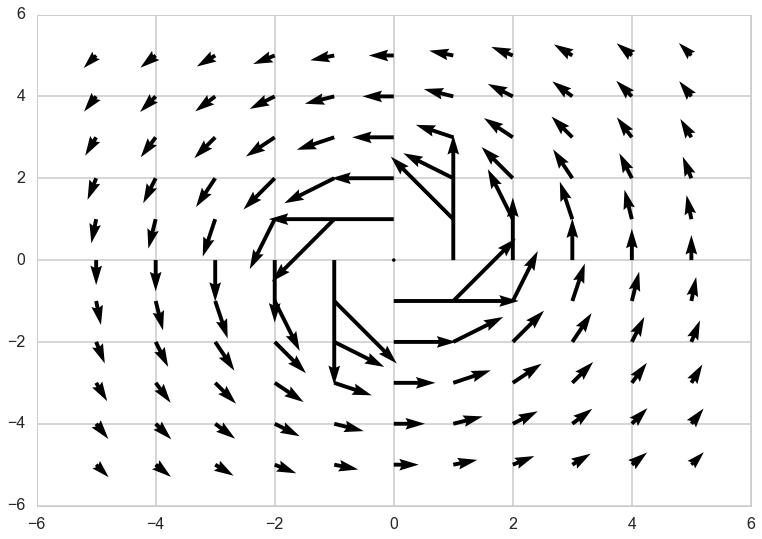

In [13]:
plt.quiver(x[:, :, 0], y[:, :, 0], 
           Bx[:, :, 0], By[:, :, 0])

# Do curl manually

In [14]:
kx1 = np.zeros(x[0, :, 0].size) 
ky1 = np.zeros(y[:, 0, 0].size)
kz1 = np.zeros(z[0, 0, :].size)
    
dx = np.diff(x[0, :, 0])[0]
dy = np.diff(y[:, 0, 0])[0]
dz = np.diff(z[0, 0, :])[0]
    
nx = kx1.size
ny = ky1.size
nz = kz1.size
    
for i in np.arange(0, np.round(nx/2)):
    kx1[i] = np.float(i)/nx/2./dx
for i in np.arange(np.round(nx/2), nx):
    kx1[i] = (np.float(i) - nx)/nx/2./dx
        
for i in np.arange(0, np.round(ny/2)):
    ky1[i] = np.float(i)/ny/2./dy
for i in np.arange(np.round(ny/2), ny):
    ky1[i] = (np.float(i) - ny)/ny/2./dy
        
for i in np.arange(0, np.round(nz/2)):
    kz1[i] = np.float(i)/nz/2./dz
for i in np.arange(np.round(nz/2), nz):
    kz1[i] = (np.float(i) - nz)/nz/2./dz

In [15]:
shape = Bx.shape
np.pad(Bx, pad_width=((11, 11), (11, 11), (11, 11)), mode='reflect')

array([[[-0.01989437, -0.01989437, -0.01989437, ..., -0.01989437,
         -0.01989437, -0.01989437],
        [-0.01552731, -0.01552731, -0.01552731, ..., -0.01552731,
         -0.01552731, -0.01552731],
        [-0.01989437, -0.01989437, -0.01989437, ..., -0.01989437,
         -0.01989437, -0.01989437],
        ..., 
        [-0.01989437, -0.01989437, -0.01989437, ..., -0.01989437,
         -0.01989437, -0.01989437],
        [-0.01552731, -0.01552731, -0.01552731, ..., -0.01552731,
         -0.01552731, -0.01552731],
        [-0.01989437, -0.01989437, -0.01989437, ..., -0.01989437,
         -0.01989437, -0.01989437]],

       [[-0.01940914, -0.01940914, -0.01940914, ..., -0.01940914,
         -0.01940914, -0.01940914],
        [-0.01591549, -0.01591549, -0.01591549, ..., -0.01591549,
         -0.01591549, -0.01591549],
        [-0.01940914, -0.01940914, -0.01940914, ..., -0.01940914,
         -0.01940914, -0.01940914],
        ..., 
        [-0.01940914, -0.01940914, -0.01940914, ...,

In [16]:
shape

(11, 11, 11)

In [17]:
zip(shape, shape)

[(11, 11), (11, 11), (11, 11)]

# Define inverse curl function

In [18]:
def fourier_inverse_curl(Bx, By, Bz, x, y, z):
    
    shape = Bx.shape
    
    Bx_padded = np.pad(Bx, pad_width=zip(shape, shape), mode='reflect')
    By_padded = np.pad(By, pad_width=zip(shape, shape), mode='reflect')
    Bz_padded = np.pad(Bz, pad_width=zip(shape, shape), mode='reflect')
    
    kx1 = np.zeros(Bx_padded[0, :, 0].size) 
    ky1 = np.zeros(By_padded[:, 0, 0].size)
    kz1 = np.zeros(Bz_padded[0, 0, :].size)
    
    dx = np.diff(x[0, :, 0])[0]
    dy = np.diff(y[:, 0, 0])[0]
    dz = np.diff(z[0, 0, :])[0]
    
    nx = kx1.size
    ny = ky1.size
    nz = kz1.size
    
    for i in np.arange(0, np.round(nx/2)):
        kx1[i] = np.float(i)/nx/2./dx
    for i in np.arange(np.round(nx/2), nx):
        kx1[i] = (np.float(i) - nx)/nx/2./dx
        
    for i in np.arange(0, np.round(ny/2)):
        ky1[i] = np.float(i)/ny/2./dy
    for i in np.arange(np.round(ny/2), ny):
        ky1[i] = (np.float(i) - ny)/ny/2./dy
        
    for i in np.arange(0, np.round(nz/2)):
        kz1[i] = np.float(i)/nz/2./dz
    for i in np.arange(np.round(nz/2), nz):
        kz1[i] = (np.float(i) - nz)/nz/2./dz

    kx, ky, kz = np.meshgrid(kx1, ky1, kz1)
    
    Bx_k = fft.fftn(Bx_padded)
    By_k = fft.fftn(By_padded)
    Bz_k = fft.fftn(Bz_padded)

    k_squared = kx**2. + ky**2. + kz**2.
    
    Ax_k = 1j*(ky*Bz_k - kz*By_k)/k_squared
    Ay_k = 1j*(kz*Bx_k - kx*Bz_k)/k_squared
    Az_k = 1j*(kx*By_k - ky*Bx_k)/k_squared
    
    Ax_k[0, 0, 0] = 0. 
    Ay_k[0, 0, 0] = 0.
    Az_k[0, 0, 0] = 0.
    
    Ax_padded = np.abs(fft.ifftn(Ax_k))
    Ay_padded = np.abs(fft.ifftn(Ay_k))
    Az_padded = np.abs(fft.ifftn(Az_k))
    
    Ax = Ax_padded[shape[0]:shape[0]*2, shape[1]:shape[1]*2, shape[2]:shape[2]*2]
    Ay = Ay_padded[shape[0]:shape[0]*2, shape[1]:shape[1]*2, shape[2]:shape[2]*2]
    Az = Az_padded[shape[0]:shape[0]*2, shape[1]:shape[1]*2, shape[2]:shape[2]*2]
    
    B0_x = np.mean(Bx)
    B0_y = np.mean(By)
    B0_z = np.mean(Bz)

    A0_x = -(y*B0_z - z*B0_y)/2.
    A0_y = -(z*B0_x - x*B0_z)/2.
    A0_z = -(x*B0_y - y*B0_x)/2.

    Ax = Ax + A0_x
    Ay = Ay + A0_y
    Az = Az + A0_z

    return [Ax, Ay, Az]

In [19]:
def take_curl(Ax, Ay, Az, x, y, z):
    r"""    
    """
    dx = np.diff(x[0, :, 0])[0]
    dy = np.diff(y[:, 0, 0])[0]
    dz = np.diff(z[0, 0, :])[0]
    
    Ax_dx = np.gradient(Ax, dx, axis=1)
    Ax_dy = np.gradient(Ax, dy, axis=0)
    Ax_dz = np.gradient(Ax, dz, axis=2)
    Ay_dx = np.gradient(Ay, dx, axis=1)
    Ay_dy = np.gradient(Ay, dy, axis=0)
    Ay_dz = np.gradient(Ay, dz, axis=2)
    Az_dx = np.gradient(Az, dx, axis=1)
    Az_dy = np.gradient(Az, dy, axis=0)
    Az_dz = np.gradient(Az, dz, axis=2)
    Bx = Az_dy - Ay_dz
    By = Ax_dz - Az_dx 
    Bz = Ay_dx - Ax_dy
    return [Bx, By, Bz]

In [20]:
A_from_B_uniform = fourier_inverse_curl(B_uniform[0], B_uniform[1], B_uniform[2], x, y, z)
A_from_B_wire = fourier_inverse_curl(B_wire[0], B_wire[1], B_wire[2], x, y, z)

/home/jensv/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in divide
/home/jensv/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in divide
/home/jensv/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide


In [21]:
B_reconstructed_uniform = take_curl(A_from_B_uniform[0], 
                                    A_from_B_uniform[1], 
                                    A_from_B_uniform[2], 
                                    x, y, z)

In [22]:
B_reconstructed_wire = take_curl(A_from_B_wire[0], 
                                 A_from_B_wire[1], 
                                 A_from_B_wire[2], 
                                 x, y, z)

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

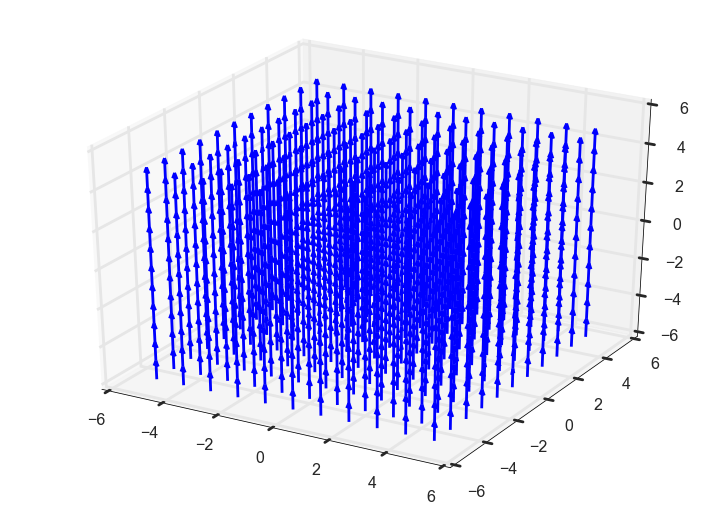

In [24]:
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d') 
axes.quiver(x, y, z, B_reconstructed_uniform[0], 
            B_reconstructed_uniform[1], 
            B_reconstructed_uniform[2])

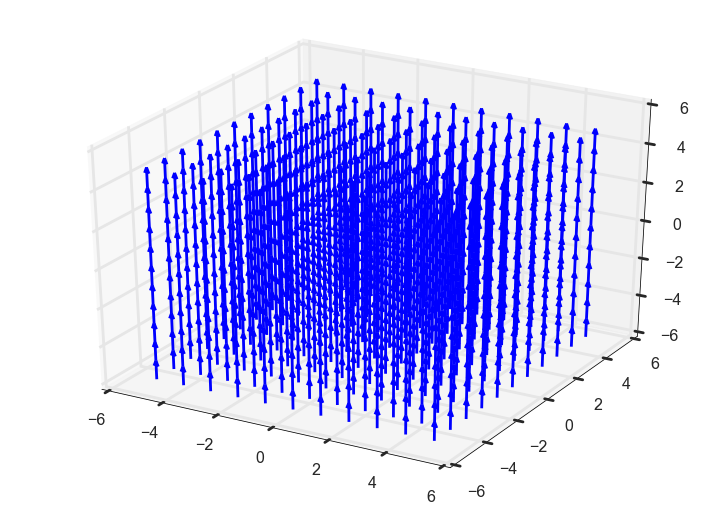

In [25]:
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d') 
axes.quiver(x, y, z, Bx_uni[0], 
            By_uni[1], 
            Bz_uni[2])

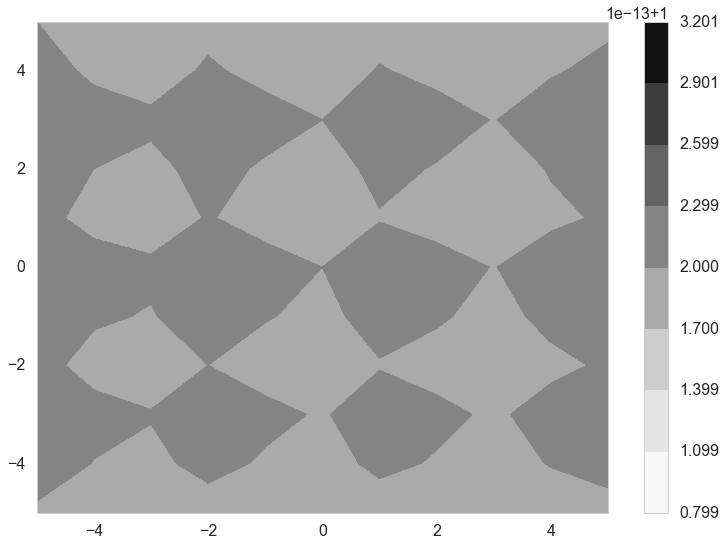

In [26]:
plt.contourf(x[:, :, 0], y[:, :, 0], 
             B_reconstructed_uniform[2][:, :, 0])
plt.colorbar()

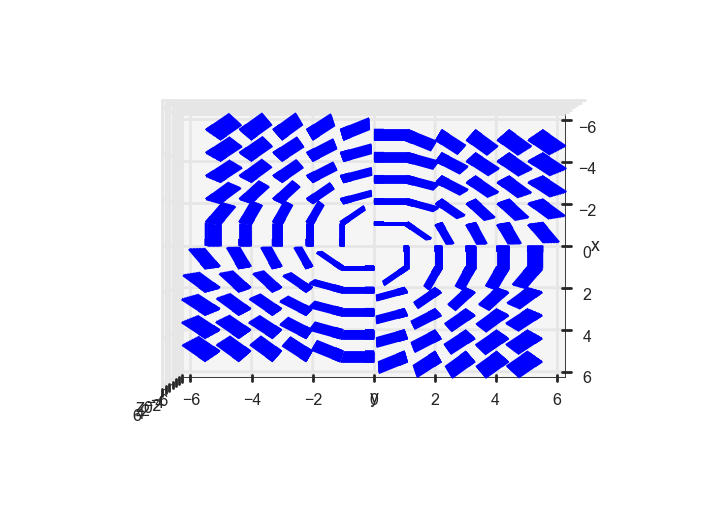

In [27]:
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d') 
axes.quiver(x, y, z, B_reconstructed_wire[0], 
            B_reconstructed_wire[1], 
            B_reconstructed_wire[2])
axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_zlabel('z')
axes.view_init(elev=90, azim=0)

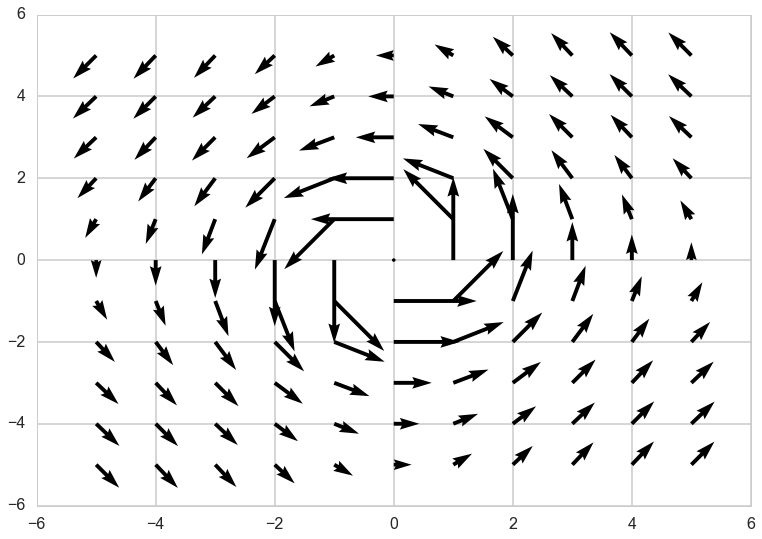

In [28]:
plt.quiver(x[:, :, 0], y[:, :, 0], 
           B_reconstructed_wire[0][:, :, 0], 
           B_reconstructed_wire[1][:, :, 0])